### A Look at Error Rates

In everything we have done so far we have, perhaps implicitly, assumed that the variance remained stable.
Under this assumption, we derived that the RMSE was the maximum likelihood estimator for the variance.
Using that fact, we were able to make those lovely pictures of potential futures using monte carlo
simulations.
In this topic we will move away from that assumption. To work out the best way to look at variable error
rates, we will go back to the source and do the calculations using maximum likelihood statistics. The
property of having varaiable variance is called Heteroskedasticity or Heteroscedasticity. hetero comes from the
Greek for different; skedactic coems from the Greek for dispersion.
So, first of all, how good was our assumption of constant variance? Let's look at the Tesla data.

In [5]:
import pandas as pd
import yfinance
import matplotlib.pyplot as plt
import numpy as np

<AxesSubplot:>

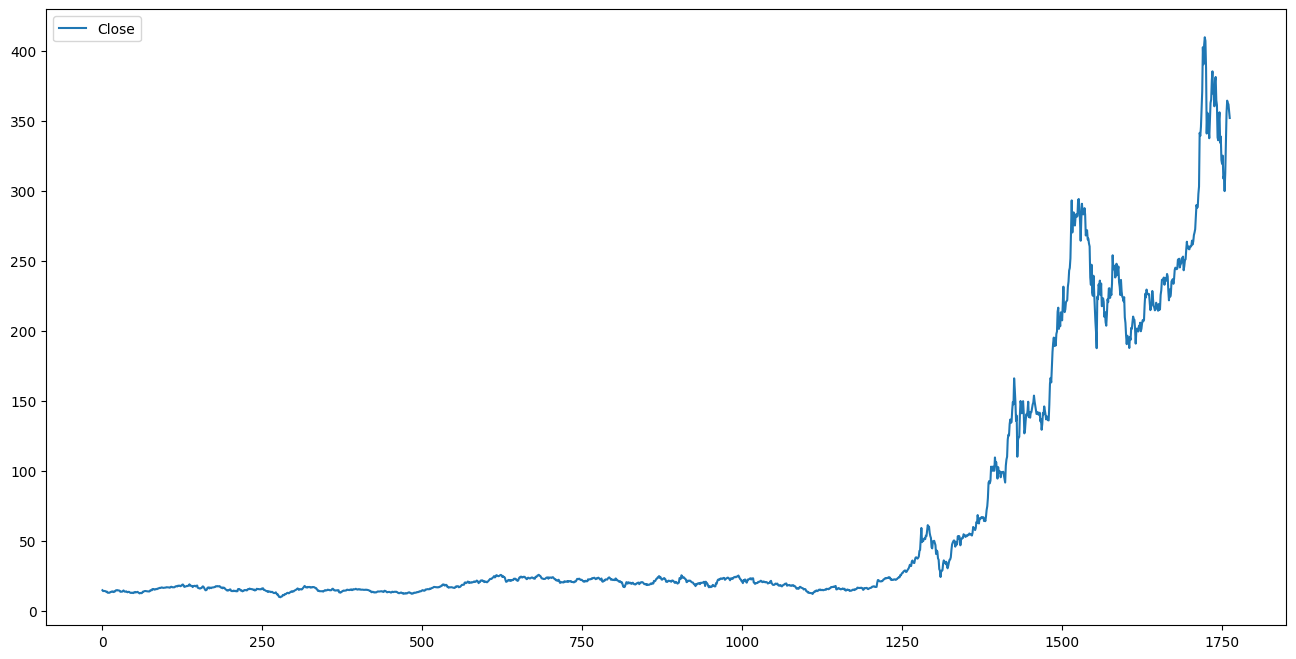

In [8]:
    tesla_frame = yfinance.Ticker('TSLA').history(start='2015-01-01', end='2022-01-01', interval='1d').reset_index()['Close'].to_frame()
plt.rcParams['figure.figsize'] = [16,8]

series = tesla_frame['Close']
tesla_frame.plot()

A lot less variance on left side of plot vs right.   
Have a lot less confidence predicting the right-hand side   
The more variation, the less confidence  

**Going to predict error as something that varies over time** 

Want to look at the variance as it changes across the series  

Look at batches of size 11 - 5 points before and 5 after current point and calculate variance  

Will need to do something different at the start and end of the series

In [12]:

def variance(series):
    # making an np-array of zeros the same length of the closing prices
    var = np.zeros(len(series))

    # then replace all but first and last 5 by the local variance
    for i in range(5, len(series) - 5):
        next_var = np.var(series[ i - 5 : i + 5])
        var[i] = next_var
    # replace last 5 with the last variance computed
    for i in range (len(series) - 5, len(series)):
        var[i] = next_var
    return var

print(variance(series)[10:20])
print(variance(series)[1000:1020])

[0.12631636 0.12549562 0.14460205 0.12954134 0.13204893 0.10914673
 0.11857408 0.15424864 0.18380918 0.23874238]
[1.51248789 0.87404833 0.69020813 0.73670555 0.63068263 0.76001496
 0.87167866 0.66180711 0.82956214 0.93085201 0.93298027 1.01970913
 0.87539811 0.33651675 0.72533256 1.3279213  2.18080848 2.6740375
 2.71956056 2.50758377]


Can see that the variance is a lot bigger for later values

<AxesSubplot:>

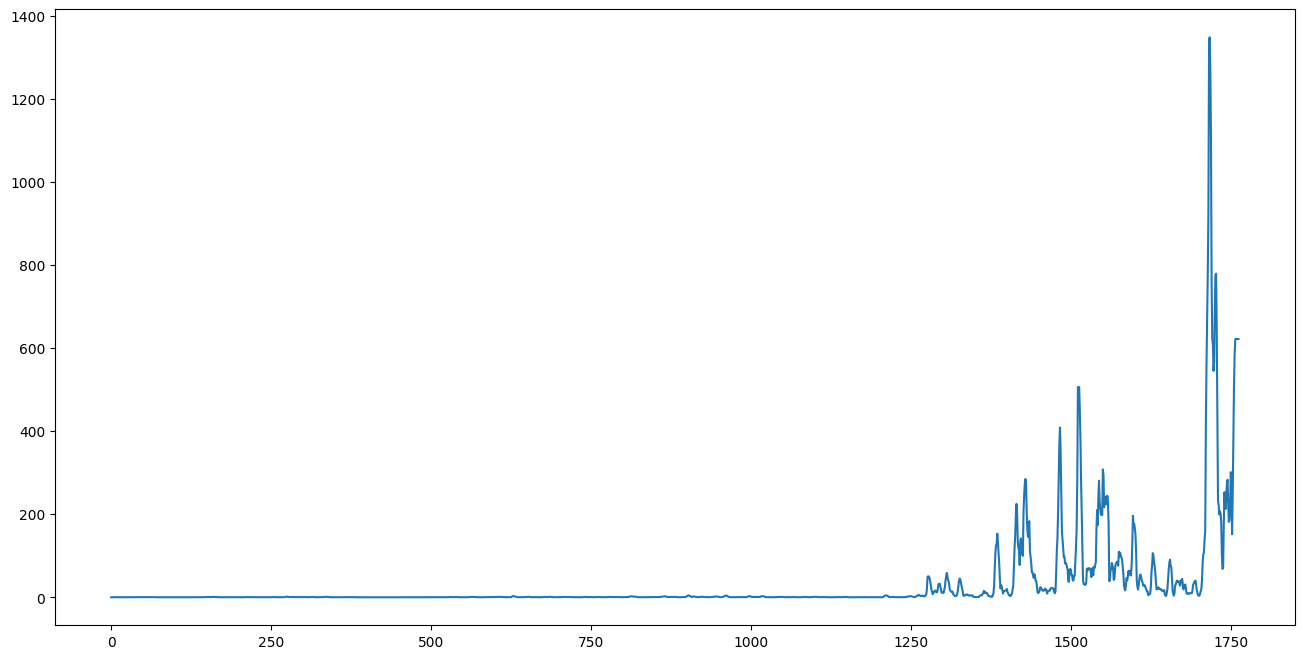

In [13]:
tesla_frame['Variances'] = variance(series)
tesla_frame['Variances'].plot()

Look at standard deviations

<AxesSubplot:>

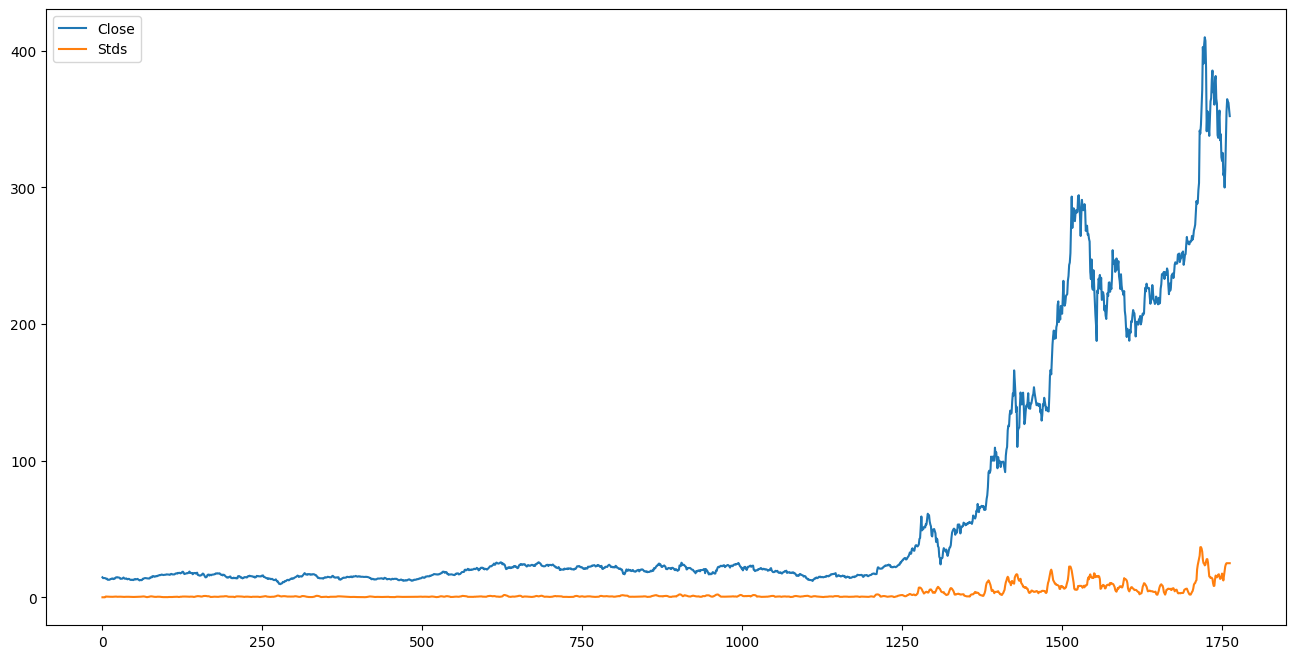

In [14]:
tesla_frame_new = tesla_frame.drop(columns = ['Variances'])
tesla_frame_new ['Stds'] = np.sqrt(tesla_frame['Variances'])
tesla_frame_new.plot()

not sure if that's better or worse - but can see much more variation later on  

what want to know is the effect on predictions  

General idea is greater variance => harder predictions

Look at AR(4) Model


<AxesSubplot:>

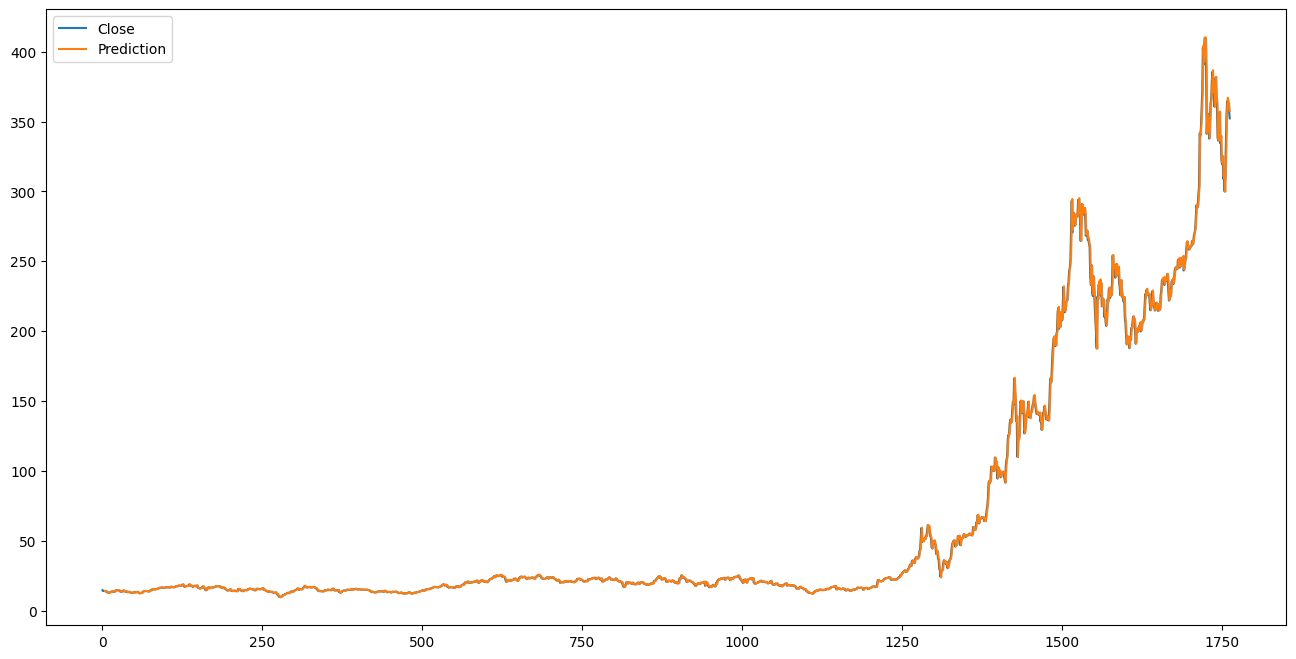

In [15]:
import statsmodels.api as sm
import math

def rmse(predicted, actual):
    diffs = predicted - actual
    return math.sqrt(np.mean(diffs ** 2))

ar_deg = 4

model = sm.tsa.AutoReg(tesla_frame['Close'], lags=ar_deg, trend='n').fit()
prediction = model.predict()
tesla_frame_prediction = tesla_frame.drop(columns = ['Variances'])
tesla_frame_prediction['Prediction'] = prediction
tesla_frame_prediction.plot()

Plot errors to see how much harder it is to predict with the higher volatility


<AxesSubplot:>

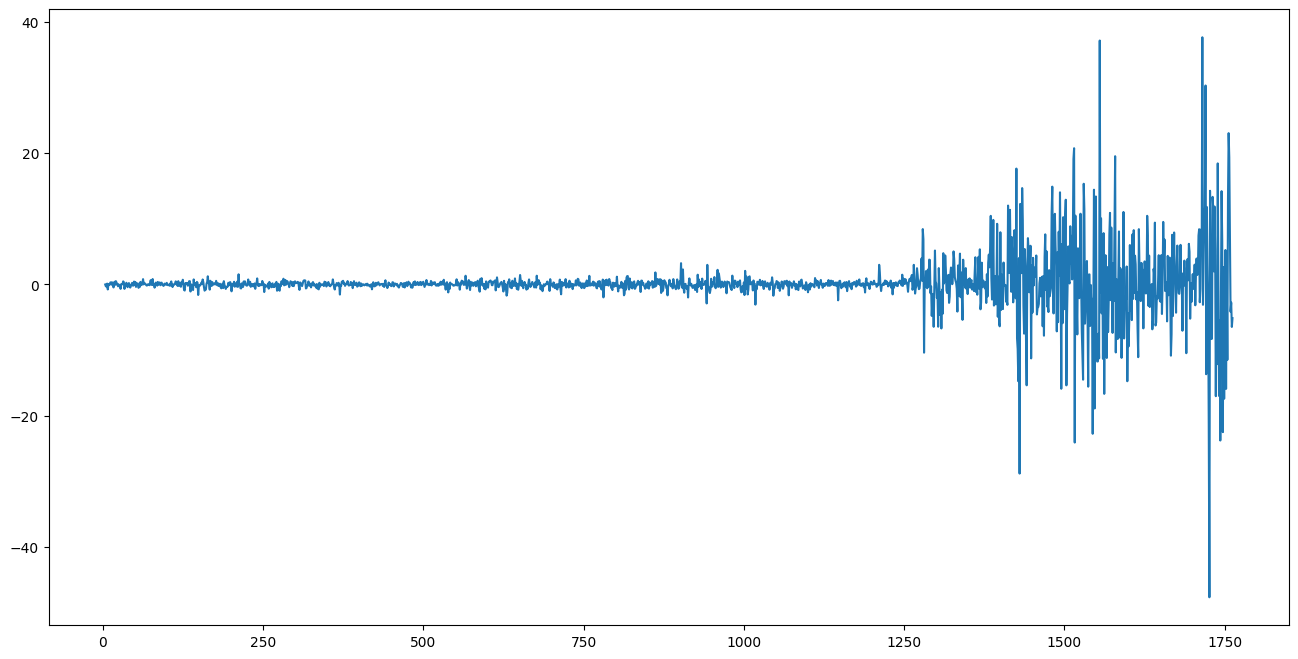

In [16]:
(tesla_frame['Close'] - prediction).plot()

- centered around 0, unbiased estimator
- magnitude of the squared error
    - predict 23 but prediction of square of the error is 9
    - know prediction between 20 or 26
- going to work out confid intervals that vary along prediction time frame


Some of the larger errors could be result of larger magnitude of closing price  
So plot relative errors = error / values  



<AxesSubplot:>

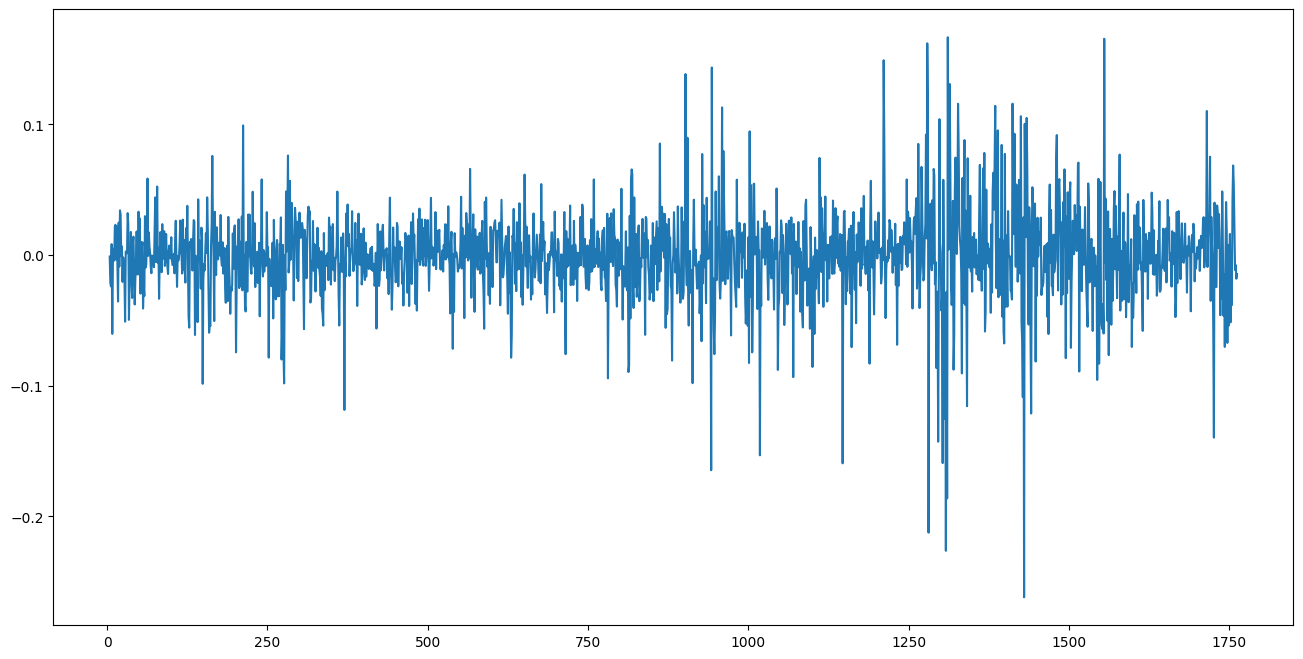

In [17]:
((tesla_frame['Close'] - prediction)/tesla_frame['Close']).plot()

Errors still go up to the right 

Look at the square of the error



<AxesSubplot:>

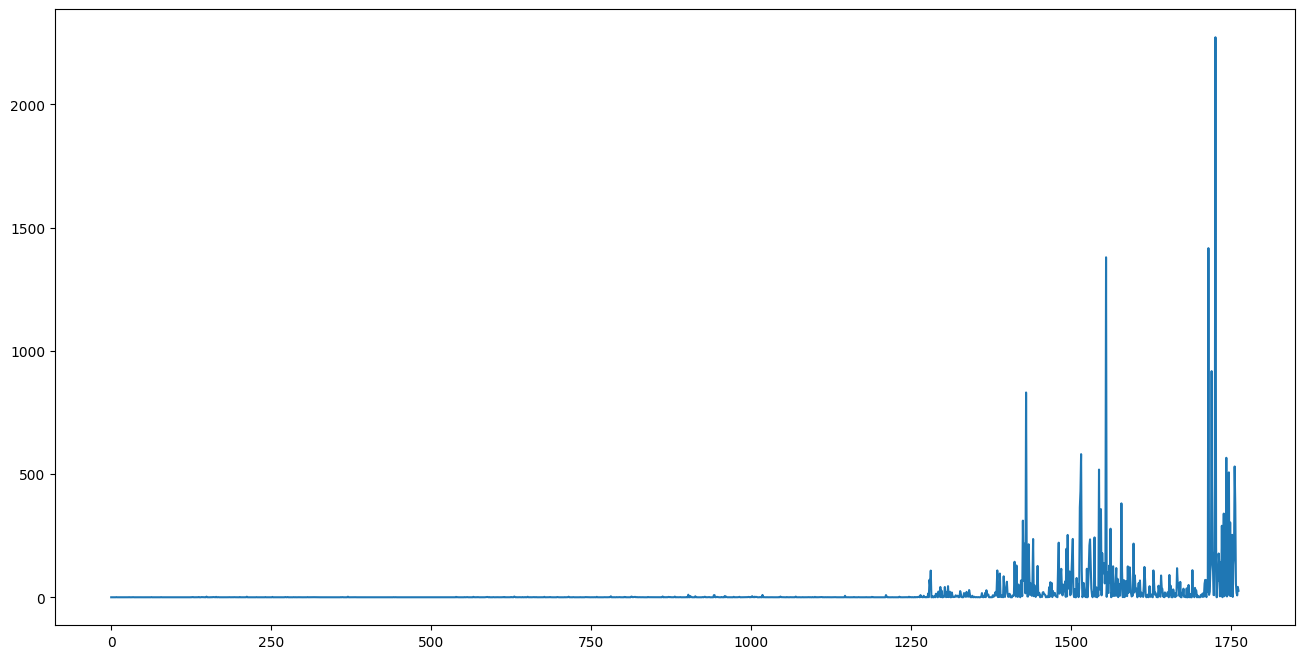

In [18]:

error_sq = (series - prediction) ** 2
error_sq[error_sq.isna()] = 0
error_sq.plot()

Compare relation with variance



<AxesSubplot:>

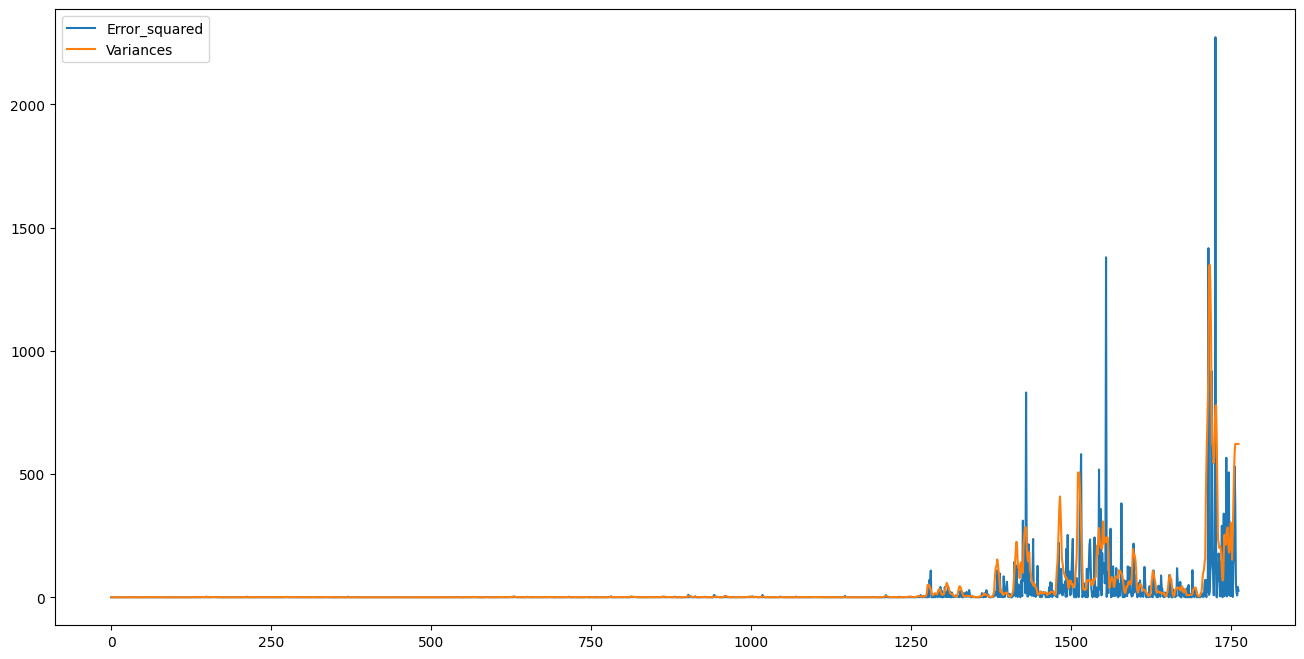

In [19]:
tesla_error_frame = pd.DataFrame()
tesla_error_frame['Error_squared'] = error_sq
tesla_error_frame['Variances'] = variance(series)
tesla_error_frame.plot()

This series is multiplicative - so take logs and plot prediction errors of the log of the series 

AR rmse 0.034552338759304975


<AxesSubplot:>

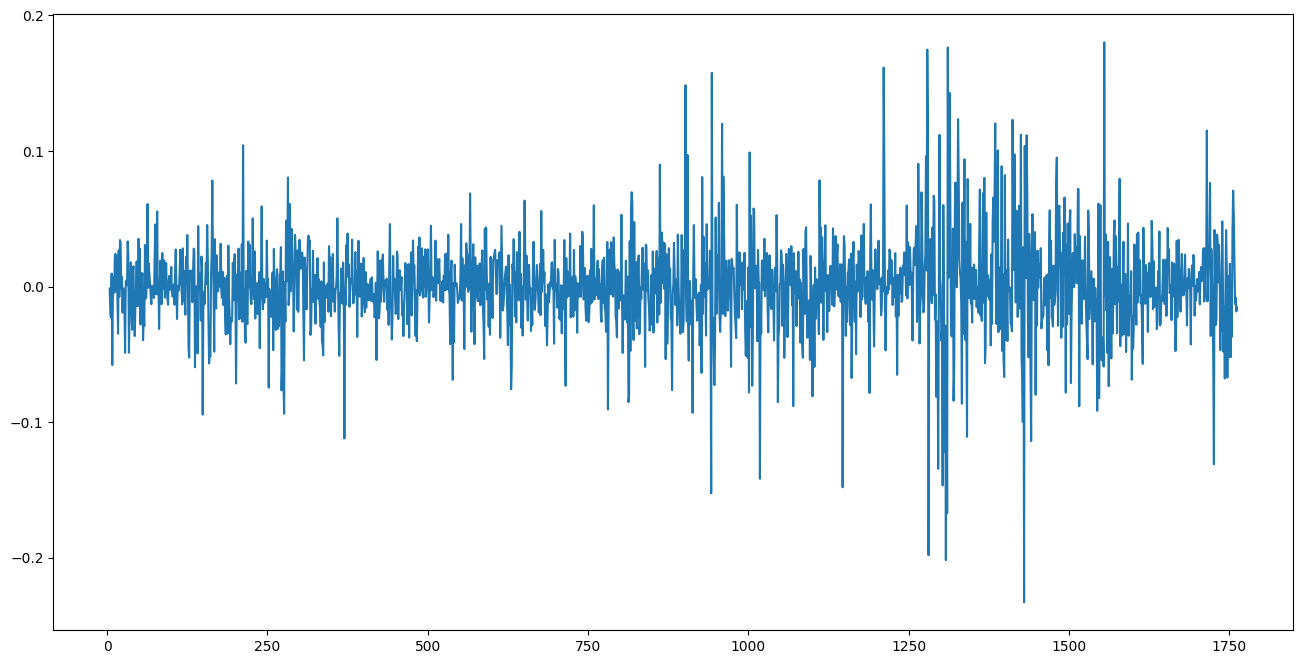

In [20]:
series = np.log(series)
model = sm.tsa.AutoReg(series, lags=ar_deg, trend='n').fit()
prediction = model.predict()
ar_rmse = rmse(prediction, series)
print("AR rmse", ar_rmse)
error_sq = (series - prediction) ** 2
error_sq[error_sq.isna()] = 0
(series - prediction).plot()

<AxesSubplot:>

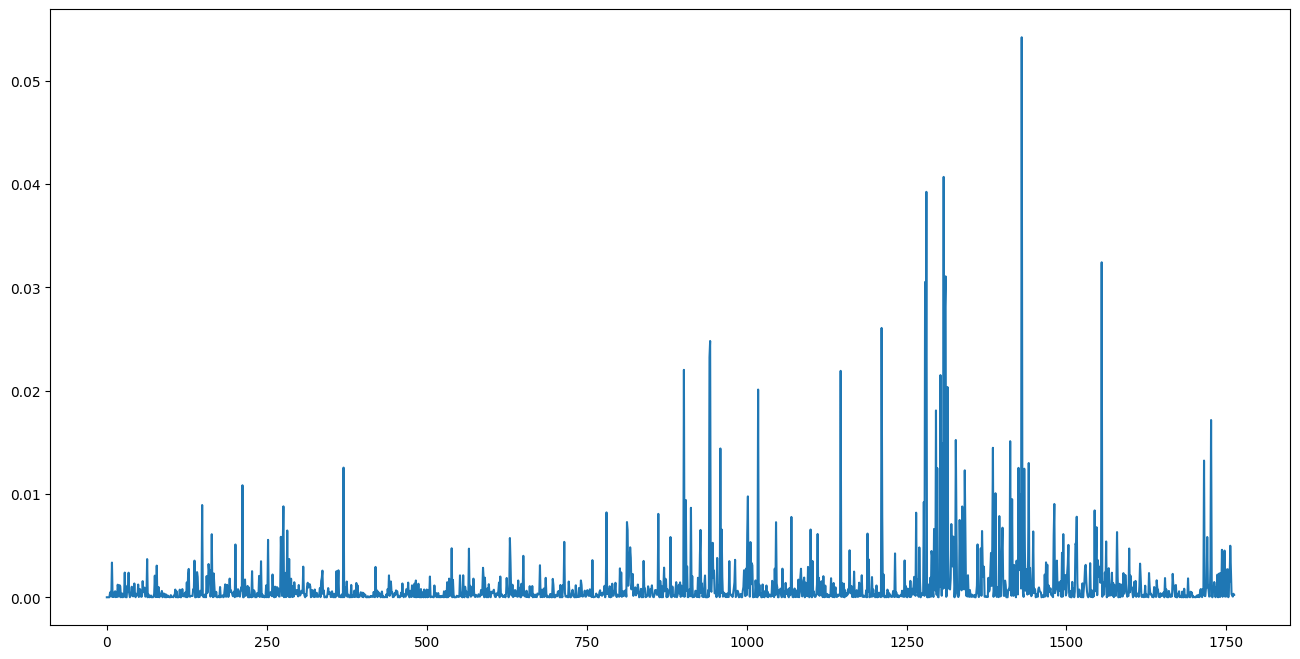

In [21]:
# squares of the error
error_sq.plot()